# MIE451/1513 Decision Support System -- Data Science Solution

## Be sure to let us know:
i. what location you chose (and remember to sign up on Piazza so there are no duplicates)

* **Chilliwack, BC**

ii. what preprocessing steps you implemented

* **I renamed the rating score column as groundtruth and the groundtruth sentiment column as sentiment.**
* **The crawler crawled lots of hotels from the neighboring cities. I just select the hotels for my chosen city or around my chosen city. The filepath should match 'data/ca/154927'**
* **I noticed that the city name for the records for my chosen city are empty. So I assigned the city name "Chilliwach" to the city column**
* **Address for some hotels are wrongly shown on Tripadvisor. I changed these addresses to the correct addresses based on Google Map. For example, some addresses contain city name as well then I need to separate it.**
* **Delete all records for hotel 'Joe&#39;s Salmon Lodge' since it is pretty far from Chilliwack, Tripadvisor gives wrong address.**
* **Some hotels have relatively few reviews. I remove the hotels with fewer than 5 reviews. Since those hotels are not representative.**




In [1]:
#Plot
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
%matplotlib inline

#Data Packages
import math
import pandas as pd
import numpy as np

#Progress bar
from tqdm import tqdm

#Counter
from collections import Counter

#Operation
import operator

#Natural Language Processing Packages
import re
import nltk

## Download Resources
nltk.download("vader_lexicon")
nltk.download("stopwords")
nltk.download("averaged_perceptron_tagger")
nltk.download("wordnet")

from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
from nltk import tokenize
from nltk.corpus import stopwords
from nltk.tag import PerceptronTagger
from nltk.data import find

## Machine Learning
import sklearn
import sklearn.metrics as metrics

## Data Visualization
import folium
from tabulate import tabulate
from scipy.stats.kde import gaussian_kde
import branca
import branca.colormap as cm
from IPython.display import Image

## Geolocation
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning:

The twython library has not been installed. Some functionality from the twitter package will not be available.



# Q1 Sentiment Analysis and Aggregation

In [2]:
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', 500)

In [3]:
#Read in from pandas
columnNames = ['filePath','hotelName','reviewColumn','groundTruth','sentiment',
               'date_stamp','streetAddress', 'City',
               'Province','postalCode']

hotelDf = pd.read_csv('reviews.csv',
                          header=None,
                          names=columnNames)

In [4]:
hotelDf.head()

,filePath,hotelName,reviewColumn,groundTruth,sentiment,date_stamp,streetAddress,City,Province,postalCode
0,data/ca/154927/188394/708844691.html,Travelodge Chilliwack,"""Room was absolutely disgusting! Previous occupants food still in the fridge, bedding was dirty, stunk so bad of mildew and smoke. We\u2019ve stayed here many times before and never had a problem but this hotel has gone way downhill. We will never be back.",1,negative,"September 11, 2019",45466 Yale Rd,NaN,British Columbia,V2R 3Z8
1,data/ca/154927/188394/283226647.html,Travelodge Chilliwack,"""Had a great stay after a long road trip with small children. Right off the highway so nice and easy to continue our trip in the morning. Plunge pool and hot tub were a great way to unwind. Tanner at front desk was awesomely friendly and efficient.",4,positive,"June 26, 2015",45466 Yale Rd,NaN,British Columbia,V2R 3Z8
2,data/ca/154927/188394/452467258.html,Travelodge Chilliwack,"""Stayed week of July 18, 2016 for one night. Surprisingly good because the area appears industrial and from the outside, this hotel does not look inviting. However, once inside, the lobby appears to belong to a more upscale hotel and the professional staff make up for any initial misgivings. The carpet in the upstairs hallway is definitely well used which is unfortunate since otherwise everything appeared new and clean.\nOur room was sufficiently large, the beds, although a bit hard, were co...",5,positive,"January 16, 2017",45466 Yale Rd,NaN,British Columbia,V2R 3Z8
3,data/ca/154927/188394/115329691.html,Travelodge Chilliwack,"""I recently just stayed at the hotel with my family and our 4 dogs. We had just moved down here to Chilliwack from Alberta. Our stay was excellent. The staff was very friendly and accommodating. They showed us our neighborhood and what are the bad and good areas of town. They were very friendly in allowing us to stay longer than scheduled due to our moving truck not arriving in town on time. The hotel is very clean and smells fresh due to the renovations. We couldn't hear the renovations whi...",5,positive,"July 13, 2011",45466 Yale Rd,NaN,British Columbia,V2R 3Z8
4,data/ca/154927/188394/268760160.html,Travelodge Chilliwack,"""Decent hotel that met all our needs without exceeding any expectations. Front desk staff were kind and helpful throughout our 3-night stay, answering all our questions and splitting payments on checkout. The room was really clean, and the housekeeping staff were awesome!\nWe went to use the pool a couple times, and it was a nice asset, but the hot tub was only lukewarm on our second visit, and its water looked consistently dirty. Other than that, my only issue was the wifi, which was not al...",4,positive,"April 28, 2015",45466 Yale Rd,NaN,British Columbia,V2R 3Z8


In [5]:
#The crawler crawled lots of hotels from the neighboring cities. I just select the hotels for my chosen city
hotelDf = hotelDf[hotelDf['filePath'].str.match('data/ca/154927')]

In [6]:
#The City name shows NaN for the city I chose. I assign it with my chosen city name
hotelDf.loc[:,'City'] = 'Chilliwack'

In [7]:
set(hotelDf['hotelName'].values)

{'Chilliwack Bed and Breakfast',
 'Coast Chilliwack Hotel by APA',
 'Comfort Inn',
 'Cottage Garden Bed &amp; Breakfast',
 'Cultus Cottages',
 'Forest Echoes Cabins',
 'Hampton Inn By Hilton Chilliwack',
 'Joe&#39;s Salmon Lodge',
 'Magnolia Manor Bed &amp; Breakfast Chilliwack, Canada',
 'Rainbow Motor Inn',
 'Riverbend Guest House B&amp;B',
 'Riverview B&amp;B',
 'SureStay Hotel By Best Western Chilliwack',
 'The Fraser River&#39;s Edge B&amp;B Lodge',
 'The Royal Hotel Chilliwack',
 'Travelodge Chilliwack',
 'Vedder River Inn',
 'White Pillars Country Estate B&amp;B'}

In [8]:
#Address for some hotels are wrongly shown on Tripadvisor. I changed these addresses to the correct address based on Google Map

hotelDf.loc[hotelDf['hotelName'] == 'SureStay Hotel By Best Western Chilliwack', 'streetAddress'] = "43971 Industrial Way"

hotelDf.loc[hotelDf['hotelName'] == 'Cultus Cottages', 'streetAddress'] = "1785 Columbia Valley Highway"
hotelDf.loc[hotelDf['hotelName'] == 'Cultus Cottages', 'City'] = "Cultus Lake"

hotelDf.loc[hotelDf['hotelName'] == 'Magnolia Manor Bed &amp; Breakfast Chilliwack, Canada', 'streetAddress'] = "46013 Gore Ave"

hotelDf.loc[hotelDf['hotelName'] == 'Forest Echoes Cabins', 'City'] = "Cultus Lake"

hotelDf.loc[hotelDf['hotelName'] == 'Riverbend Guest House B&amp;B', 'streetAddress'] = "50691 O'Byrne Rd"

## (a) Compute average Vader sentiment and average ground truth rating per hotel.


In [9]:
def avg_Vader_Rating_per_hotel(input_df):
    #Instantiate an instance to access SentimentIntensityAnalyzer class
    input_df = input_df[['hotelName','reviewColumn','groundTruth']]
    sentences = input_df['reviewColumn'].values
    sid = SentimentIntensityAnalyzer()
    pdlist = []
    for sentence in tqdm(sentences):
        ss = sid.polarity_scores(sentence)
        pdlist.append(ss['compound'])
    input_df['vader'] = pdlist
    input_df.columns = ['hotelName','n_reviews','AverageGroundTruthRating','AverageVader']
    input_df = input_df.groupby('hotelName').agg({'n_reviews':'count', 'AverageGroundTruthRating':'mean','AverageVader':'mean'})
    return input_df

In [10]:
AvgDf_original = avg_Vader_Rating_per_hotel(hotelDf)

100%|██████████| 1902/1902 [00:02<00:00, 942.14it/s] 
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [11]:
#Delete 'Joe&#39;s Salmon Lodge' this hotel since it is pretty far from Chilliwack, Tripadvisor gives wrong address
AvgDf_original = AvgDf_original.drop(index='Joe&#39;s Salmon Lodge')

In [12]:
#Select hotels with >5 reviews.
AvgDf = AvgDf_original[AvgDf_original['n_reviews'] > 5]

In [13]:
#Remove the hotels with fewer than 5 reviews
Hotel_names = AvgDf.index.values
AvgDf

,n_reviews,AverageGroundTruthRating,AverageVader
hotelName,,,
Coast Chilliwack Hotel by APA,215,4.330233,0.760412
Comfort Inn,115,3.504348,0.639842
Forest Echoes Cabins,8,4.750000,0.918925
Hampton Inn By Hilton Chilliwack,408,4.529412,0.828365
Rainbow Motor Inn,19,3.684211,0.640511
Riverbend Guest House B&amp;B,15,4.733333,0.863427
Riverview B&amp;B,100,4.960000,0.926026
SureStay Hotel By Best Western Chilliwack,310,4.270968,0.805232
The Fraser River&#39;s Edge B&amp;B Lodge,130,4.976923,0.951797


## (b) Rank hotels by (i) Average Ground Truth Sentiment (ii) Average Vader Compound Sentiment Score. Show both top-5 and bottom-5 for both ranking methods. Do they agree? If not discuss any differences.

In [14]:
AverageGroundTruthRatingTop5 = AvgDf.reset_index(drop=False)\
                               .sort_values('AverageGroundTruthRating',ascending=False)[['hotelName','AverageGroundTruthRating']].head(5)
AverageGroundTruthRatingTop5

,hotelName,AverageGroundTruthRating
8,The Fraser River&#39;s Edge B&amp;B Lodge,4.976923
6,Riverview B&amp;B,4.960000
2,Forest Echoes Cabins,4.750000
5,Riverbend Guest House B&amp;B,4.733333
3,Hampton Inn By Hilton Chilliwack,4.529412


In [15]:
AverageVaderTop5 = AvgDf.reset_index(drop=False)\
                               .sort_values('AverageVader',ascending=False)[['hotelName','AverageVader']].head(5)
AverageVaderTop5

,hotelName,AverageVader
8,The Fraser River&#39;s Edge B&amp;B Lodge,0.951797
6,Riverview B&amp;B,0.926026
2,Forest Echoes Cabins,0.918925
5,Riverbend Guest House B&amp;B,0.863427
3,Hampton Inn By Hilton Chilliwack,0.828365


In [16]:
AverageGroundTruthRatingBot5 = AvgDf.reset_index(drop=False)\
                               .sort_values('AverageGroundTruthRating',ascending=True)[['hotelName','AverageGroundTruthRating']].head(5)
AverageGroundTruthRatingBot5

,hotelName,AverageGroundTruthRating
10,Travelodge Chilliwack,3.066667
1,Comfort Inn,3.504348
11,Vedder River Inn,3.670000
4,Rainbow Motor Inn,3.684211
9,The Royal Hotel Chilliwack,4.219355


In [17]:
AverageVaderBot5 = AvgDf.reset_index(drop=False)\
                               .sort_values('AverageVader',ascending=True)[['hotelName','AverageVader']].head(5)
AverageVaderBot5

,hotelName,AverageVader
10,Travelodge Chilliwack,0.436826
1,Comfort Inn,0.639842
4,Rainbow Motor Inn,0.640511
11,Vedder River Inn,0.662507
0,Coast Chilliwack Hotel by APA,0.760412


*  For top-5 hotels, both ranking methods give exactly the same results. 
*  However, for the bottom-5 hotels, the results are slightly different. The first 2 hotels are the same. For example, Rainbow Motor Inn is ranked at bottom 4 using Average Ground Truth and at bottom 3 using Average Vader. And Rainbow Motor Inn and Vedder River Inn are just at the opposite ranks. The 5th bottom hotels are different based on these two methods.

# Q2 Frequency Analysis

## (a) Use term frequency of the words for (i) positive reviews and (ii) negative with ground truth sentiment to rank the top-50 most frequent non-stopwords in the review collection. Which words appear to be location specific? What words appear in both positive and negative reviews? Do any words that appear in both lists surprise you?

In [18]:
def get_stop_words():
    stop = set(stopwords.words('english'))
    #Add possible Stop Words for Hotel Reviews
    stop.add('hotel')
    stop.add('room')
    stop.add('rooms')
    stop.add('stay')
    stop.add('staff')
    return stop

In [19]:
def get_final_df(input_df):
    #Instantiate an instance to access SentimentIntensityAnalyzer class
    input_df = input_df[['hotelName','reviewColumn','groundTruth','sentiment']]
    sentences = input_df['reviewColumn'].values
    sid = SentimentIntensityAnalyzer()
    pdlist = []
    for sentence in tqdm(sentences):
        ss = sid.polarity_scores(sentence)
        pdlist.append(ss['compound'])
    input_df['vader'] = pdlist

    return input_df

In [20]:
finalDf = get_final_df(hotelDf)

100%|██████████| 1902/1902 [00:02<00:00, 944.49it/s] 
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [21]:
#Remove the hotels with very few reviews
finalDf = finalDf[finalDf['hotelName'].isin(Hotel_names)].reset_index(drop=True)
finalDf

,hotelName,reviewColumn,groundTruth,sentiment,vader
0,Travelodge Chilliwack,"""Room was absolutely disgusting! Previous occupants food still in the fridge, bedding was dirty, stunk so bad of mildew and smoke. We\u2019ve stayed here many times before and never had a problem but this hotel has gone way downhill. We will never be back.",1,negative,-0.7316
1,Travelodge Chilliwack,"""Had a great stay after a long road trip with small children. Right off the highway so nice and easy to continue our trip in the morning. Plunge pool and hot tub were a great way to unwind. Tanner at front desk was awesomely friendly and efficient.",4,positive,0.9682
2,Travelodge Chilliwack,"""Stayed week of July 18, 2016 for one night. Surprisingly good because the area appears industrial and from the outside, this hotel does not look inviting. However, once inside, the lobby appears to belong to a more upscale hotel and the professional staff make up for any initial misgivings. The carpet in the upstairs hallway is definitely well used which is unfortunate since otherwise everything appeared new and clean.\nOur room was sufficiently large, the beds, although a bit hard, were co...",5,positive,0.9535
3,Travelodge Chilliwack,"""I recently just stayed at the hotel with my family and our 4 dogs. We had just moved down here to Chilliwack from Alberta. Our stay was excellent. The staff was very friendly and accommodating. They showed us our neighborhood and what are the bad and good areas of town. They were very friendly in allowing us to stay longer than scheduled due to our moving truck not arriving in town on time. The hotel is very clean and smells fresh due to the renovations. We couldn't hear the renovations whi...",5,positive,0.9908
4,Travelodge Chilliwack,"""Decent hotel that met all our needs without exceeding any expectations. Front desk staff were kind and helpful throughout our 3-night stay, answering all our questions and splitting payments on checkout. The room was really clean, and the housekeeping staff were awesome!\nWe went to use the pool a couple times, and it was a nice asset, but the hot tub was only lukewarm on our second visit, and its water looked consistently dirty. Other than that, my only issue was the wifi, which was not al...",4,positive,0.7405
...,...,...,...,...,...
1855,Riverbend Guest House B&amp;B,"""The owner was very thoughtful and helped us to find wonderful things to do while in Chilliwack. She went out of her way to make us feel truly welcomed. The only cabin on the property was large and spacious. The handmade bed was beautiful. There was a good selection of movies to watch and a guide to places to visit provided. I would definitely like to go back again.",5,positive,0.9716
1856,Riverbend Guest House B&amp;B,"""we stayed in the cabin, as we have been many times before this trip was as good as the first , we had 4 days sturgeon fishing on the fraser river with riversport fishing and once again came up trumps ,I caught 17 with 4 under 5ft all the rest were over 6ft 6ins with the best at 8ft 10ins,we travelled between mission and hope when we were not fishing and saw wonderfull scenery and wildlife. hope to go back again.",5,positive,0.9169
1857,Riverbend Guest House B&amp;B,"""we as a group previousley stayed at the riverbend in 2005 when it was under the stewardship of wayne and betty, the accomodation was first class, nothing was too much trouble, the food and facilities were excellent , trip was made all the more enjoyable with the quiet location in slesse park in which it is situated, would we visit again, definately",5,positive,0.6361
1858,Riverbend Guest House B&amp;B,"""Came up to the Guest House twice, once with a group and again as a couple, both times were fantastic with Jess and Jay being so helpful with everything. It is a great location with everything close by including Cultus Lake. I would reccommend Riverbend to anyone with Jess and Jay really going out of their way to make our stay memoriable.",5,posit

In [105]:
finalDf.groupby('sentiment').agg('count')

,hotelName,reviewColumn,groundTruth,vader
sentiment,,,,
negative,392,392,392,392
positive,1468,1468,1468,1468


In [22]:
def getTopK(df, kwords, label_column, operation=operator.eq, value_column='reviewColumn', label_value = None):
    stop = get_stop_words()
    counter = Counter()
    if label_value is None:
        reviews = df[value_column].values
    else:
        reviews = df.loc[operation(df[label_column],label_value)][value_column]
    for review in reviews:
          counter.update([word.lower() 
                          for word 
                          in re.findall(r'\w+', review) 
                          if word.lower() not in stop and len(word) > 2])
    topk = counter.most_common(kwords)
    return topk

In [103]:
topkGroundPos = getTopK(finalDf, 50, label_column='sentiment', label_value='positive')
topkGroundPos

[('great', 856),
 ('clean', 805),
 ('breakfast', 744),
 ('good', 556),
 ('friendly', 511),
 ('nice', 481),
 ('would', 454),
 ('comfortable', 416),
 ('stayed', 399),
 ('chilliwack', 397),
 ('pool', 393),
 ('place', 377),
 ('area', 329),
 ('well', 321),
 ('time', 316),
 ('one', 294),
 ('hot', 271),
 ('helpful', 269),
 ('night', 261),
 ('location', 255),
 ('quiet', 238),
 ('back', 235),
 ('food', 226),
 ('restaurant', 223),
 ('service', 218),
 ('river', 210),
 ('definitely', 208),
 ('excellent', 208),
 ('recommend', 207),
 ('family', 201),
 ('like', 201),
 ('really', 193),
 ('bed', 193),
 ('best', 192),
 ('tub', 191),
 ('desk', 190),
 ('close', 189),
 ('front', 186),
 ('beds', 185),
 ('everything', 183),
 ('get', 181),
 ('could', 180),
 ('also', 179),
 ('day', 178),
 ('home', 174),
 ('always', 170),
 ('made', 169),
 ('wonderful', 162),
 ('enjoyed', 161),
 ('next', 158)]

In [24]:
topkGroundNeg = getTopK(finalDf, 50, label_column='sentiment', label_value='negative')
topkGroundNeg

[('would', 207),
 ('night', 163),
 ('front', 158),
 ('desk', 148),
 ('clean', 147),
 ('good', 146),
 ('one', 142),
 ('could', 133),
 ('breakfast', 128),
 ('like', 125),
 ('get', 120),
 ('bed', 114),
 ('stayed', 113),
 ('place', 113),
 ('back', 98),
 ('time', 97),
 ('nice', 96),
 ('pool', 92),
 ('floor', 85),
 ('friendly', 84),
 ('people', 83),
 ('got', 82),
 ('well', 81),
 ('check', 78),
 ('nthe', 77),
 ('area', 75),
 ('even', 73),
 ('day', 72),
 ('also', 71),
 ('bathroom', 67),
 ('first', 67),
 ('hot', 67),
 ('restaurant', 66),
 ('never', 65),
 ('dirty', 64),
 ('around', 64),
 ('said', 64),
 ('great', 63),
 ('told', 63),
 ('two', 63),
 ('door', 62),
 ('small', 62),
 ('sleep', 62),
 ('tub', 60),
 ('coffee', 60),
 ('booked', 60),
 ('chilliwack', 60),
 ('beds', 59),
 ('right', 59),
 ('location', 57)]

In [25]:
def get_shared_words(list1, list2):
    words1 = list(zip(*list1))[0]
    words2 = list(zip(*list2))[0]
    shared_words = list(set(words1).intersection(words2))
    return shared_words

In [104]:
get_shared_words(topkGroundPos, topkGroundNeg)

['like',
 'nice',
 'also',
 'back',
 'one',
 'desk',
 'area',
 'restaurant',
 'chilliwack',
 'night',
 'time',
 'well',
 'would',
 'front',
 'pool',
 'stayed',
 'bed',
 'friendly',
 'get',
 'location',
 'beds',
 'great',
 'clean',
 'hot',
 'breakfast',
 'tub',
 'place',
 'could',
 'good',
 'day']

* Some words are location specific. For example, "chilliwack", "pool", "location", "resturant", "place", "area".
* Some words appear in both positive and negative reviews with high frequency. For example, "like", "cilliwack", "desk", "area", etc. The above list shows it.
* Yes some words do surprise me, such as "nice", "friendly", "great", "good" which are positive words but they appear in the negative list as well.

## (b) Repeat this analysis for the top-50 noun phrases (using the provided grammar pattern below). Do any noun phrases appear in both positive and negative reviews? Identify a noun phrase you did not expect to see in the positive reviews and explain why it may be there.

In [27]:
grammar = r"""
    NBAR:
        {<NN.*|JJ>*<NN.*>}  # Nouns and Adjectives, terminated with Nouns
        
    NP:
        {<NBAR>}
        {<NBAR><IN><NBAR>}  # Above, connected with in/of/etc...
"""
chunker = nltk.RegexpParser(grammar)

tagger = PerceptronTagger()
pos_tag = tagger.tag

In [28]:
lemmatizer = nltk.WordNetLemmatizer()
stemmer = nltk.stem.porter.PorterStemmer()
stopword_list = get_stop_words()

# generator, create item one a time
def get_terms(tree):
    for leaf in leaves(tree):
        term = [normalise(w) for w,t in leaf if acceptable_word(w) ]
        # Phrase only
        if len(term)>1:
            yield term

# generator, generate leaves one by one
def leaves(tree):
    """Finds NP (nounphrase) leaf nodes of a chunk tree."""
    for subtree in tree.subtrees(filter = lambda t: t.label()=='NP' or t.label()=='JJ' or t.label()=='RB'):
        yield subtree.leaves()

# stemming, lematizing, lower case... 
def normalise(word,lemmatizer=lemmatizer, stemmer=stemmer):
    """Normalises words to lowercase and stems and lemmatizes it."""
    word = word.lower()
    word = stemmer.stem(word)
    word = lemmatizer.lemmatize(word)
    return word

# stop-words and length control
def acceptable_word(word, stopword_list=stopword_list):
    """Checks conditions for acceptable word: length, stopword."""
    accepted = bool(2 <= len(word) <= 40
        and word.lower() not in stopword_list)
    return accepted

# Flatten phrase lists to get tokens for analysis
def flatten_phrase_lists(npTokenList):
    finalList =[]
    for phrase in npTokenList:
        token = ''
        for word in phrase:
            token += word + ' '
        finalList.append(token.rstrip())
    return finalList

In [29]:
def getTopKNP(df, kNPs, label_column, operation=operator.eq, value_column='reviewColumn', label_value=None):

    counter = Counter()
    if label_value is None:
        reviews = df[value_column].values
    else:
        reviews = df.loc[operation(df[label_column],label_value)][value_column]

    for review in reviews:
            counter.update(flatten_phrase_lists([word
                            for word 
                            in get_terms(chunker.parse(pos_tag(re.findall(r'\w+', review)))) 
                            ]))
    topk = counter.most_common(kNPs)
    return topk

In [30]:
topk_phraseGroundPos = getTopKNP(finalDf, 50, label_column='sentiment', label_value='positive') 
topk_phraseGroundPos

[('hot tub', 103),
 ('front desk', 92),
 ('hampton inn', 50),
 ('great place', 41),
 ('fraser river', 40),
 ('complimentari breakfast', 32),
 ('pool area', 26),
 ('comfort bed', 25),
 ('fraser river edg', 25),
 ('industri area', 24),
 ('next time', 23),
 ('park lot', 22),
 ('water slide', 22),
 ('good valu', 21),
 ('great valu', 20),
 ('first time', 20),
 ('vedder river inn', 20),
 ('continent breakfast', 20),
 ('easi access', 20),
 ('great time', 18),
 ('best western', 18),
 ('great locat', 17),
 ('tim horton', 17),
 ('next morn', 16),
 ('next day', 15),
 ('coast chilliwack', 15),
 ('includ breakfast', 14),
 ('next year', 13),
 ('free breakfast', 13),
 ('reason price', 13),
 ('great servic', 13),
 ('great price', 12),
 ('hot breakfast', 12),
 ('breakfast area', 12),
 ('great breakfast', 12),
 ('great view', 12),
 ('beauti view', 12),
 ('second floor', 11),
 ('long day', 11),
 ('chilliwack bc', 11),
 ('chilliwack area', 11),
 ('long time', 11),
 ('stun view', 11),
 ('mike adriana', 11)

In [31]:
topk_phraseGroundNeg = getTopKNP(finalDf, 50,label_column='sentiment', label_value='negative') 
topk_phraseGroundNeg

[('front desk', 72),
 ('park lot', 24),
 ('comfort inn', 24),
 ('hot tub', 23),
 ('second floor', 14),
 ('credit card', 13),
 ('ground floor', 10),
 ('next morn', 10),
 ('doubl bed', 10),
 ('next day', 8),
 ('sever time', 8),
 ('vedder river inn', 8),
 ('front desk clerk', 7),
 ('pool area', 7),
 ('pet friendli', 6),
 ('free breakfast', 6),
 ('travel lodg', 6),
 ('complimentari breakfast', 6),
 ('good valu', 6),
 ('custom servic', 6),
 ('tim horton', 6),
 ('next time', 6),
 ('good place', 6),
 ('queen bed', 6),
 ('wheelchair access', 5),
 ('ice machin', 5),
 ('homeless peopl', 5),
 ('first time', 5),
 ('good rate', 5),
 ('hot water', 5),
 ('front desk person', 5),
 ('first night', 5),
 ('traffic nois', 5),
 ('best western', 5),
 ('mani time', 4),
 ('desk clerk', 4),
 ('phone call', 4),
 ('decent bed', 4),
 ('decent place', 4),
 ('book com', 4),
 ('ihop restaur', 4),
 ('young kid', 4),
 ('front door', 4),
 ('good thing', 4),
 ('cigarett butt', 4),
 ('second day', 4),
 ('breakfast area',

In [32]:
get_shared_words(topk_phraseGroundPos, topk_phraseGroundNeg)

['second floor',
 'queen bed',
 'breakfast area',
 'pool area',
 'tim horton',
 'vedder river inn',
 'first time',
 'next morn',
 'good valu',
 'next time',
 'next day',
 'complimentari breakfast',
 'front desk',
 'free breakfast',
 'hot tub',
 'doubl bed',
 'best western',
 'park lot',
 'hampton inn']

* The noun phrases that appear in both reviews are shown above.
* I do not expect to see 'coast chilliwack' in positive reviews since this noun phrase just indicates the location, which does not have any sentiment. But it still appears in the positive reviews. This is because it is a location specific noun phrase. I choose the city Chilliwack and the reviews (no matter positive or negative) will contain this location noun phrase with high frequency. We can treat it as a stop word.

## (c) Repeat this analysis again for the top-50 noun phrases using your own defined grammar pattern. Note at least 3 observations on the similarities or differences between these noun phrases and those in Q2(b). Which pattern do you think is more effective for sentiment analysis and why?

In [33]:
defined_grammar = r"""
    NBAR:
        {<RB|RBR|RBS>*<NN.*|JJ|JJR|JJS>}  # Nouns and Adverbs(all forms) and Adjectives(all forms), terminated with Nouns, The Nouns can be before Adv. and Adj.
        
    NP:
        {<NBAR>}
        {<NBAR><IN><NBAR>}  # Above, connected with in/of/etc...
"""
defined_chunker = nltk.RegexpParser(defined_grammar)
tagger = PerceptronTagger()
pos_tag = tagger.tag

In [34]:
#def test_grammar(text):
    #counter = Counter()

    #for review in text:
            #counter.update(flatten_phrase_lists([word
                            #for word 
                            #in get_terms(defined_chunker.parse(pos_tag(re.findall(r'\w+', review)))) 
                            #]))
    #return counter

In [35]:
#text = ['big desk of sad clerk, . cat. dog pig make']
#text = ['happy strong pig was', 'highly extremely strongly crazy men women go']
#test_grammar(text)

In [36]:
def getTopKNP_modified(df, kNPs, label_column, operation=operator.eq, value_column='reviewColumn', label_value=None):

    counter = Counter()
    if label_value is None:
        reviews = df[value_column].values
    else:
        reviews = df.loc[operation(df[label_column],label_value)][value_column]

    for review in reviews:
            counter.update(flatten_phrase_lists([word
                            for word 
                            in get_terms(defined_chunker.parse(pos_tag(re.findall(r'\w+', review)))) 
                            ]))
    topk = counter.most_common(kNPs)
    return topk

In [37]:
topk_phraseGroundPos_modified = getTopKNP_modified(finalDf, 50, label_column='sentiment', label_value='positive') 
topk_phraseGroundPos_modified

[('realli good', 19),
 ('back next', 13),
 ('extrem comfort', 10),
 ('extrem friendli', 9),
 ('realli nice', 9),
 ('pretti good', 8),
 ('alway avail', 8),
 ('much better', 7),
 ('alway clean', 7),
 ('realli great', 6),
 ('extrem clean', 6),
 ('well kept', 6),
 ('realli clean', 5),
 ('realli friendli', 5),
 ('alway good', 5),
 ('also good', 5),
 ('quit good', 5),
 ('alway will', 5),
 ('realli comfort', 4),
 ('friendli great', 4),
 ('also clean', 4),
 ('yr old', 4),
 ('extrem help', 4),
 ('alway great', 4),
 ('easili access', 4),
 ('highli recommend', 4),
 ('fairli new', 4),
 ('alway happi', 3),
 ('well lit', 3),
 ('pretti quiet', 3),
 ('friendli help', 3),
 ('quit larg', 3),
 ('environment friendli', 3),
 ('right next', 3),
 ('pretti much', 3),
 ('realli warm', 3),
 ('realli help', 3),
 ('absolut amaz', 3),
 ('even better', 3),
 ('also abl', 3),
 ('spotlessli clean', 3),
 ('well furnish', 3),
 ('rel new', 3),
 ('awesom friendli', 2),
 ('surprisingli good', 2),
 ('otherwis everyth', 2),


In [38]:
topk_phraseGroundNeg_modified = getTopKNP_modified(finalDf, 50, label_column='sentiment', label_value='negative') 
topk_phraseGroundNeg_modified

[('quit good', 7),
 ('extrem loud', 5),
 ('realli bad', 4),
 ('realli nice', 3),
 ('much better', 3),
 ('quit small', 3),
 ('realli good', 3),
 ('liter right', 3),
 ('pretti good', 3),
 ('front desk', 3),
 ('extrem small', 2),
 ('much good', 2),
 ('incred loud', 2),
 ('extrem difficult', 2),
 ('quit hard', 2),
 ('alway peopl', 2),
 ('fairli basic', 2),
 ('absolut noth', 2),
 ('pretti much', 2),
 ('fulli wheelchair', 1),
 ('extrem rude', 1),
 ('nobvious none', 1),
 ('realli hard', 1),
 ('terribl busi', 1),
 ('elsewher news', 1),
 ('better front', 1),
 ('fairli quiet', 1),
 ('better price', 1),
 ('surprisingli quiet', 1),
 ('long stori', 1),
 ('still overli', 1),
 ('well stock', 1),
 ('quit noisi', 1),
 ('back home', 1),
 ('spotlessli clean', 1),
 ('final abl', 1),
 ('el leg', 1),
 ('disgustingli filthi', 1),
 ('extrem clean', 1),
 ('definit overpr', 1),
 ('almost black', 1),
 ('clearli clean', 1),
 ('quit place', 1),
 ('realli murki', 1),
 ('el garbag', 1),
 ('back also sketchi', 1),
 (

In [39]:
get_shared_words(topk_phraseGroundPos_modified, topk_phraseGroundNeg_modified)

['realli good',
 'pretti much',
 'quit good',
 'much better',
 'extrem clean',
 'realli nice',
 'spotlessli clean',
 'pretti good']

* There are lots of difference between the noun phrases using my own defined grammar and the default grammar from Q2(b). I think my defined grammar is more effective for sentiment analysis since I use Adverbs and Adjectives with their original, comparative and superlative as well. Usually Adverbs and Adjectives, sometimes Verbs as well, will directly reflect the sentiments and reflect something that is positive or negative. Therefore I used this grammar. However, the number of reviews for the hotels in this city are not very large so the frequency of these words are small.

# Q3 Mutual Information

## (a) Use mutual information (MI) with ground truth sentiment to rank the top-50 most sentiment- bearing non-stopwords in the review collection. Which words get the highest MI values? Does this make sense?

In [40]:
def getMI(topk, df, label_column='sentiment'):
    miScore = []
    for word in topk:
        miScore.append([word[0]]+[metrics.mutual_info_score(df[label_column], df[word[0]])])
    miScoredf = pd.DataFrame(miScore).sort_values(1,ascending=0)
    miScoredf.columns = ['Word','MI Score']
    return miScoredf.round(6)

In [41]:
def dataFrameTransformation(finalDf, topk):
    #Find out if a particular review has the word from topk list
    sentences = finalDf['reviewColumn'].values
    freqReview = []
    for i in range(len(sentences)):
        tempCounter = Counter([word.lower() for word in re.findall(r'\w+',sentences[i])])
        topkinReview = [1 if tempCounter[word] > 0 else 0 for (word,wordCount) in topk]
        freqReview.append(topkinReview)
               
    #Prepare freqReviewDf
    freqReviewDf = pd.DataFrame(freqReview)
    dfName = []
    for c in topk:
        dfName.append(c[0])
    freqReviewDf.columns = dfName
    finaldf_with_words = finalDf.join(freqReviewDf)
    return finaldf_with_words

In [42]:
def NPdataFrameTransformation(finalDf, topk, grammar_chunker):
    #Find out if a particular review has the word from topk list
    sentences = finalDf['reviewColumn'].values
    freqReview = []
    for i in range(len(sentences)):
        tempCounter = Counter(flatten_phrase_lists([word 
                                       for word 
                                       in get_terms(grammar_chunker.parse(pos_tag(re.findall(r'\w+',sentences[i]))))]))
        topkinReview = [1 if tempCounter[word] > 0 else 0 for (word,wordCount) in topk]
        freqReview.append(topkinReview)
               
    #Prepare freqReviewDf
    freqReviewDf = pd.DataFrame(freqReview)
    dfName = []
    for c in topk:
        dfName.append(c[0])
    freqReviewDf.columns = dfName
    finaldf_with_phrases = finalDf.join(freqReviewDf)
    return finaldf_with_phrases

In [43]:
topk = getTopK(finalDf, 500, label_column='sentiment', label_value=None)

In [44]:
finaldf_with_words = dataFrameTransformation(finalDf, topk)

In [45]:
miScoredf = getMI(topk, finaldf_with_words)

In [46]:
miScoredf.head(50)

,Word,MI Score
209,dirty,0.034544
1,great,0.031574
77,floor,0.017235
17,front,0.017049
468,carpet,0.016150
438,poor,0.016150
22,could,0.015886
374,cleaned,0.015314
110,never,0.015289
19,desk,0.014874


* The top-50 most sentiment bearing non-stopwords are shown above. "dirty" gets the highest MI values. This makes sense. Because mutual information measure the information that 2 variables share. It measures how much knowing one variable can reduct the uncertainty of another variable. High mutual information indicates the lower uncertainty of another variable, given one variable. This means "dirty" can indicates "positive" or "negative" well which makes sense since "dirty" is a kind of negative sentiment word.

## (b) Repeat this analysis for the top-50 noun phrases using the grammar you found most effective in Q2. Which noun phrases get the highest MI values? Based on these results what would you recommend the hotels in your city might need to improve?

In [47]:
topk_phrase = getTopKNP_modified(finalDf, 500, label_column='sentiment', label_value=None)

In [48]:
finaldf_with_phrase = NPdataFrameTransformation(finalDf, topk_phrase, defined_chunker)

In [49]:
miScoredf_phrase = getMI(topk_phrase, finaldf_with_phrase)

In [50]:
miScoredf_phrase.head(50)

,Word,MI Score
17,extrem loud,0.004199
22,realli bad,0.003357
41,liter right,0.002516
48,front desk,0.002516
68,alway peopl,0.001676
60,extrem small,0.001676
61,much good,0.001676
62,incred loud,0.001676
64,extrem difficult,0.001676
67,quit hard,0.001676


* "extrem loud" gets the highest MI value. This makes sense as well since "extrem loud" indicates negative sentiment well.
* Based on these two analysis, I recommend the hotels in my city to pay attention to the hygiene, public health and cleaning. Also the hotel might need to do some noice control to reduce the noise pollution from both outside and inside of the hotel (might need to install some noise insulation equipments).

# Q4 Pointwise Mutual Information

## (a) For ground truth sentiment, calculate the top-50 words according to Pointwise Mutual In- formation (PMI) of the word occurring with (i) positive reviews and (ii) negative reviews. Discuss at least 3 interesting and/or locale-specific findings about these top-ranked words.

In [51]:
#px: Total positive and negative reviews
#py: Total number of reviews that the word appears
#pxy: The number of reviews that the word appears in positive or negative

#Some words may only appear in positive/regative reviews, pxy may = 0, we add 0.0001 to pxy
#Some hotels may only have positive/negative reviews, px/py may = 0, we add 0.0001 to px*py
def pmiCalc(df, word, gt_sentiment, label_column='sentiment'):
    
    N = df.shape[0] #normalize by the sample size
    
    px = sum(df[label_column]==gt_sentiment)
    py = sum(df[word]==True)
    pxy = len(df[(df[label_column]==gt_sentiment) & (df[word]==True)])

    if pxy==0: #Log 0 cannot happen
        pmi = math.log((pxy+0.0001)*N/(px*py+0.0001))
    else:
        pmi = math.log(pxy*N/(px*py))
    return pmi

# Compute PMI for all terms and all possible labels
def pmiForAllCal(df, topk_word, gt_sentiment, label_column='sentiment'):
    #Try calculate all the pmi for top k and store them into one pmidf dataframe
    
    index = [x[0] for x in topk_word]
    pmiDf = pd.DataFrame(index=index, columns=['pmi'])

    for (word, count) in tqdm(topk_word):
        pmiDf.at[word, 'pmi'] = pmiCalc(df,word,gt_sentiment,label_column)
    
    return pmiDf

In [52]:
pmiposdf = pmiForAllCal(finaldf_with_words,topk,'positive')
pmiposdf.sort_values('pmi',ascending=0).head(50)

100%|██████████| 500/500 [00:01<00:00, 442.30it/s]


,pmi
jim,0.236676
adriana,0.236676
edge,0.236676
hospitality,0.236676
delicious,0.236676
sturgeon,0.236676
appointed,0.236676
deck,0.236676
lynne,0.236676
fraser,0.226625


In [53]:
pminegdf = pmiForAllCal(finaldf_with_words,topk,'negative')
pminegdf.sort_values('pmi',ascending=0).head(50)

100%|██████████| 500/500 [00:01<00:00, 486.71it/s]


,pmi
dirty,1.44584
poor,1.38717
carpet,1.38717
broken,1.36036
cleaned,1.31345
hallway,1.24691
loud,1.23549
later,1.18551
smell,1.17978
toilet,1.1662


* Positive words such as "hospitality", "delicious", "cozy", "beautiful", "perfect", etc. are on the positive list since these words are positively sentimental. However, some people names appear on the list as well. This may be because they own the hotels which have mostly positive sentiments.
* Negative words such as "dirty", "poor", "broken", "loud", etc. are on the negative list with high PMI and they are nevatively sentimental words as well.
* The negative word list has higher PMI score then the positive list, which indicates they are more indicative towards the sentiment than the positive words. Since the positive word list has lower PMI, they may appear in the negative reviews quite often.

## (b) Repeat this analysis for the top-50 noun phrases using your preferred grammar and discuss at least 3 interesting results.


In [54]:
topk_phrase2 = getTopKNP(finalDf, 500, label_column='sentiment', label_value=None)
finaldf_with_phrase2 = NPdataFrameTransformation(finalDf, topk_phrase2, chunker)

In [55]:
pmiposdf_phrase = pmiForAllCal(finaldf_with_phrase2,topk_phrase2,'positive')
pmiposdf_phrase.sort_values('pmi',ascending=0).head(50)

100%|██████████| 500/500 [00:00<00:00, 515.58it/s]


,pmi
hidden gem,0.236676
live area,0.236676
comfort clean,0.236676
river edg,0.236676
next trip,0.236676
fraser river edg bed breakfast lodg,0.236676
beauti sunset,0.236676
pool hot tub,0.236676
good amen,0.236676
nice clean,0.236676


In [56]:
pminegdf_phrase = pmiForAllCal(finaldf_with_phrase2,topk_phrase2,'negative')
pminegdf_phrase.sort_values('pmi',ascending=0).head(50)

100%|██████████| 500/500 [00:00<00:00, 508.36it/s]


,pmi
non smoke,1.55707
young ladi,1.55707
coupl hour,1.55707
reserv line,1.55707
strong smell,1.55707
pool noodl,1.55707
car park,1.55707
cigarett smoke,1.55707
previou guest,1.55707
main entranc,1.55707


* Similarly, noun phrase "comfort clean", "beauti sunset", etc. have high PMI score for positive reviews. And "strong smell", "cigarett smoke" "dirty sock", etc. have high PMI score for negative reviews since they are sentimental strong words.
* Based on the negative list, it looks like there might be some smoking problems which bring some odour issues.
* There are lots of noun phrases having same PMI scores, for either positive and negative list. This is because the noun phrase are too specific and they appear very few times in the overall reviews. (say both phrases appear 1 time in positive and 1 time in negative review so they have the same PMI). They appear few times,meaning there are high probability for them to get the same py and pxy. (py is how often are the words present in all reviews. pxy is the number of reviews whether the word appears in positive/negative reviews.)

## (c) Repeat this analysis for the single top and single bottom hotel (according to the ground truth rating). Do you gain any useful hotel-specific insights about what is good and bad about these two hotels? If not, explain why.

Top Hotel ('The Fraser River&#39;s Edge B&amp;B Lodge', with 130	reviews and average GroundTruth Rating 4.976923)

(All 130 reviews are positive)

Word PMI

In [57]:
def demo_pmiCal(df,word):
    pmilist=[]
    N = df.shape[0] #normalize by the total sample size
    for sentiment in ['positive','negative']:
        for word_present in [False,True]:
            px = sum(df['sentiment']==sentiment) #how many positive and negative reviews
            py = sum(df[word]==word_present) #how often are the words present in all reviews
            pxy = len(df[(df['sentiment']==sentiment) & (df[word]==word_present)])

            if pxy==0:#Log 0 cannot happen
                pmi = math.log((pxy+0.0001)*N/(px*py+0.0001))
            else:
                pmi = math.log(pxy*N/(px*py))

            pmilist.append([sentiment]+[word_present]+[px]+[py]+[pxy]+[pmi])

    # assemble the results into a dataframe
    pmidf = pd.DataFrame(pmilist)
    pmidf.columns = ['sentiment (x)','word_present (y)','px','py','pxy','pmi']
    return pmidf

In [58]:
Top_finalDf = finalDf[finalDf.hotelName == 'The Fraser River&#39;s Edge B&amp;B Lodge'].reset_index(drop=True)
Top_topk = getTopK(Top_finalDf, 500, label_column='sentiment', label_value=None)
Top_finaldf_with_words = dataFrameTransformation(Top_finalDf, Top_topk)

In [59]:
Top_pmiposdf = pmiForAllCal(Top_finaldf_with_words,Top_topk,'positive')
Top_pmiposdf.sort_values('pmi',ascending=0).head(50)

100%|██████████| 500/500 [00:00<00:00, 778.36it/s]


,pmi
river,0
beyond,0
young,0
met,0
ask,0
chance,0
seeing,0
keep,0
fruit,0
try,0


In [60]:
Top_pminegdf = pmiForAllCal(Top_finaldf_with_words,Top_topk,'negative')
Top_pminegdf.sort_values('pmi',ascending=0).head(50)

100%|██████████| 500/500 [00:00<00:00, 774.88it/s]


,pmi
river,4.86753
beyond,4.86753
young,4.86753
met,4.86753
ask,4.86753
chance,4.86753
seeing,4.86753
keep,4.86753
fruit,4.86753
try,4.86753


In [61]:
demo_pmiCal(Top_finaldf_with_words,'river')

,sentiment (x),word_present (y),px,py,pxy,pmi
0,positive,False,130,50,50,0.000000
1,positive,True,130,80,80,0.000000
2,negative,False,0,50,0,4.867534
3,negative,True,0,80,0,4.867534


Phrase PMI

In [62]:
Top_topk_phrase = getTopKNP(Top_finalDf, 500, label_column='sentiment', label_value=None)
Top_finaldf_with_phrase = NPdataFrameTransformation(Top_finalDf, Top_topk_phrase, chunker)

In [63]:
Top_pmiposdf_phrase = pmiForAllCal(Top_finaldf_with_phrase,Top_topk_phrase,'positive')
Top_pmiposdf_phrase.sort_values('pmi',ascending=0).head(50)

100%|██████████| 500/500 [00:00<00:00, 792.13it/s]


,pmi
fraser river edg,0
fantast nthe,0
bad kind,0
guarante catch,0
top notch hospit,0
alberta u002fbc adventur,0
daili hot tub,0
salmon everyday,0
guid jet boat,0
scotland mike,0


In [64]:
Top_pminegdf_phrase = pmiForAllCal(Top_finaldf_with_phrase,Top_topk_phrase,'negative')
Top_pminegdf_phrase.sort_values('pmi',ascending=0).head(50)

100%|██████████| 500/500 [00:00<00:00, 804.56it/s]


,pmi
fraser river edg,4.86753
fantast nthe,4.86753
bad kind,4.86753
guarante catch,4.86753
top notch hospit,4.86753
alberta u002fbc adventur,4.86753
daili hot tub,4.86753
salmon everyday,4.86753
guid jet boat,4.86753
scotland mike,4.86753


In [65]:
demo_pmiCal(Top_finaldf_with_phrase,'bad kind')

,sentiment (x),word_present (y),px,py,pxy,pmi
0,positive,False,130,129,129,0.000000
1,positive,True,130,1,1,0.000000
2,negative,False,0,129,0,4.867534
3,negative,True,0,1,0,4.867534


Bottom Hotel (Travelodge Chilliwack, with 285	reviews and average GroundTruth Rating 3.066667)

Word PMI

In [66]:
Bottom_finalDf = finalDf[finalDf.hotelName == 'Travelodge Chilliwack'].reset_index(drop=True)
Bottom_topk = getTopK(Bottom_finalDf, 500, label_column='sentiment', label_value=None)
Bottom_finaldf_with_words = dataFrameTransformation(Bottom_finalDf, Bottom_topk)

In [67]:
Bottom_pmiposdf = pmiForAllCal(Bottom_finaldf_with_words,Bottom_topk,'positive')
Bottom_pmiposdf.sort_values('pmi',ascending=0).head(50)

100%|██████████| 500/500 [00:00<00:00, 740.59it/s]


,pmi
relax,0.784955
thanks,0.784955
spacious,0.784955
bonus,0.679594
wonderful,0.651423
directions,0.630804
access,0.630804
visiting,0.630804
suite,0.602633
love,0.602633


In [68]:
demo_pmiCal(Bottom_finaldf_with_words,'relax')

,sentiment (x),word_present (y),px,py,pxy,pmi
0,positive,False,130,280,125,-0.021521
1,positive,True,130,5,5,0.784955
2,negative,False,155,280,155,0.017700
3,negative,True,155,5,0,-10.210714


In [69]:
Bottom_pminegdf = pmiForAllCal(Bottom_finaldf_with_words,Bottom_topk,'negative')
Bottom_pminegdf.sort_values('pmi',ascending=0).head(50)

100%|██████████| 500/500 [00:00<00:00, 742.93it/s]


,pmi
locked,0.609064
trying,0.609064
u2019t,0.609064
drugs,0.609064
hanging,0.609064
horrible,0.609064
put,0.609064
charge,0.609064
man,0.609064
rather,0.609064


In [70]:
# This word only appears in negative reviews
demo_pmiCal(Bottom_finaldf_with_words,'locked')

,sentiment (x),word_present (y),px,py,pxy,pmi
0,positive,False,130,281,130,0.014135
1,positive,True,130,4,0,-9.811680
2,negative,False,155,281,151,-0.012011
3,negative,True,155,4,4,0.609064


Phrase PMI

In [71]:
Bottom_topk_phrase = getTopKNP(Bottom_finalDf, 500, label_column='sentiment', label_value=None)
Bottom_finaldf_with_phrase = NPdataFrameTransformation(Bottom_finalDf, Bottom_topk_phrase, chunker)

In [72]:
Bottom_pmiposdf_phrase = pmiForAllCal(Bottom_finaldf_with_phrase,Bottom_topk_phrase,'positive')
Bottom_pmiposdf_phrase.sort_values('pmi',ascending=0).head(50)

100%|██████████| 500/500 [00:00<00:00, 743.25it/s]


,pmi
great job thank,0.784955
great way,0.784955
clean friendli,0.784955
next door nthe ihop,0.784955
product nroom,0.784955
modular home dealer,0.784955
valley nclose,0.784955
long road trip,0.784955
morn plung pool,0.784955
stay week,0.784955


In [73]:
demo_pmiCal(Bottom_finaldf_with_phrase,'great job thank')

,sentiment (x),word_present (y),px,py,pxy,pmi
0,positive,False,130,284,129,-0.004207
1,positive,True,130,1,1,0.784955
2,negative,False,155,284,155,0.003515
3,negative,True,155,1,0,-8.601277


In [74]:
Bottom_pminegdf_phrase = pmiForAllCal(Bottom_finaldf_with_phrase,Bottom_topk_phrase,'negative')
Bottom_pminegdf_phrase.sort_values('pmi',ascending=0).head(50)

100%|██████████| 500/500 [00:00<00:00, 734.34it/s]


,pmi
broken applianc,0.609064
readi till,0.609064
small kid,0.609064
heard anyth,0.609064
busi card,0.609064
friday even,0.609064
front desk attend,0.609064
dirti old truck stop,0.609064
black substanc,0.609064
yellow u002fbrown spot,0.609064


In [75]:
demo_pmiCal(Bottom_finaldf_with_phrase,'broken applianc')

,sentiment (x),word_present (y),px,py,pxy,pmi
0,positive,False,130,284,130,0.003515
1,positive,True,130,1,0,-8.425386
2,negative,False,155,284,154,-0.002958
3,negative,True,155,1,1,0.609064


* The top hotel I chose have all positive reviews, and this is the reason why the PMI for the positive words and phrases are all 0 since these words cannot indicate the positive/negative sentiment.So For the top hotel, we cannot get info of what is good or bad by looking at the PMI.
* For the bottom hotel, it looks like it has good housekeeping, good location but has bad odour and some garbages and public health issues.

# Q5 General Plots

**Note** Remember to save a static image of the map in the notebook

## (a) Histogram

In [76]:
def getHistogram(df, measure, title,figsize=(10,5)):
    fig = plt.figure(figsize=figsize)
    plt.title(title)
    
    if measure=='both': #To comapre both measurements, we divide rating score by 5 to make it in[0,1]
        x = [df['groundTruth'].values/5]
        y = [df['vader'].values]
        bins = np.linspace(-1, 1, 100)
        plt.hist(x, bins, label='normalized Ground Truth')
        plt.hist(y, bins, label='vader')
        plt.legend(loc='upper right')
        plt.xlabel("Value")
        plt.ylabel("Frequency")
    else:
        plt.hist(df[measure].values)

    plt.xlabel("Value")
    plt.ylabel("Frequency")

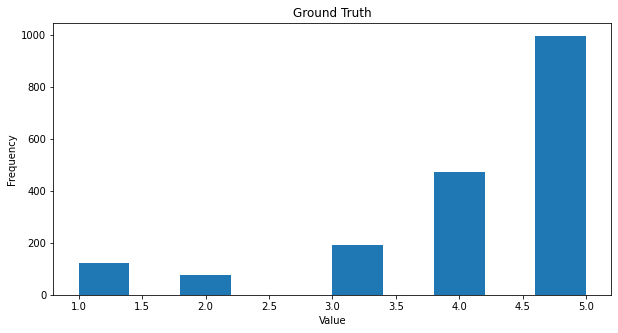

In [77]:
getHistogram(finalDf,'groundTruth', 'Ground Truth')

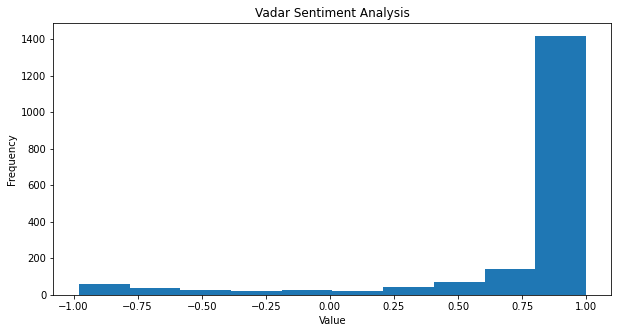

In [78]:
getHistogram(finalDf,'vader', 'Vadar Sentiment Analysis')

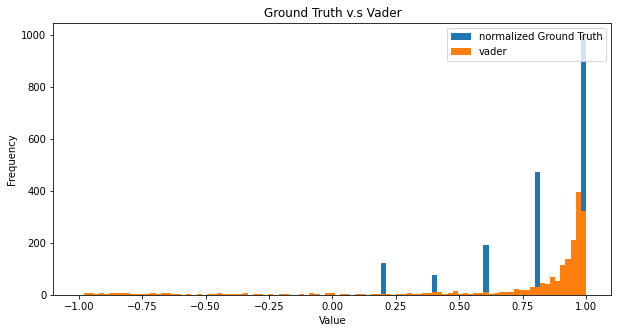

In [79]:
getHistogram(finalDf, 'both', 'Ground Truth v.s Vader')

* Both histograms are left skewed which means they tend to have higher rating as well as the vader score.
* There are some difference as well, reviews with rating score of 4 or 5 indicate pretty good vader score(from 0.75 to 1) and only some of the very reviews with very low ratings give negative vader scores.

In [80]:
AvgDf

,n_reviews,AverageGroundTruthRating,AverageVader
hotelName,,,
Coast Chilliwack Hotel by APA,215,4.330233,0.760412
Comfort Inn,115,3.504348,0.639842
Forest Echoes Cabins,8,4.750000,0.918925
Hampton Inn By Hilton Chilliwack,408,4.529412,0.828365
Rainbow Motor Inn,19,3.684211,0.640511
Riverbend Guest House B&amp;B,15,4.733333,0.863427
Riverview B&amp;B,100,4.960000,0.926026
SureStay Hotel By Best Western Chilliwack,310,4.270968,0.805232
The Fraser River&#39;s Edge B&amp;B Lodge,130,4.976923,0.951797


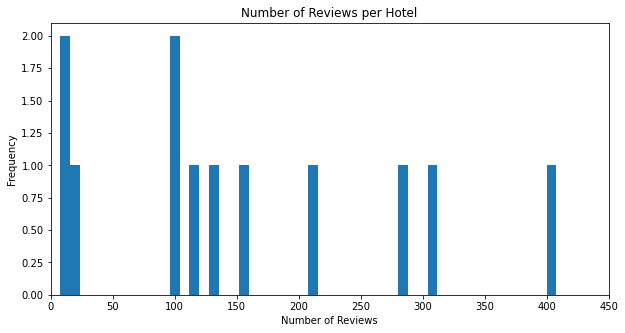

In [81]:
fig = plt.figure(figsize=(10,5))
plt.title('Number of Reviews per Hotel')
plt.hist(AvgDf['n_reviews'].values, bins = 50)
plt.xlim([0, 450])
plt.xlabel("Number of Reviews")
plt.ylabel("Frequency")
plt.show()

* The histogram is right skewed. Many hotels tend to have lower number of reviews(say 0 to 150). Only 4 hotels have more than 200 reviews. And only 1 hotel has more than 400 reviews.

## (b) Boxplots

In [82]:
AverageGroundTruthRatingTop5

,hotelName,AverageGroundTruthRating
8,The Fraser River&#39;s Edge B&amp;B Lodge,4.976923
6,Riverview B&amp;B,4.960000
2,Forest Echoes Cabins,4.750000
5,Riverbend Guest House B&amp;B,4.733333
3,Hampton Inn By Hilton Chilliwack,4.529412


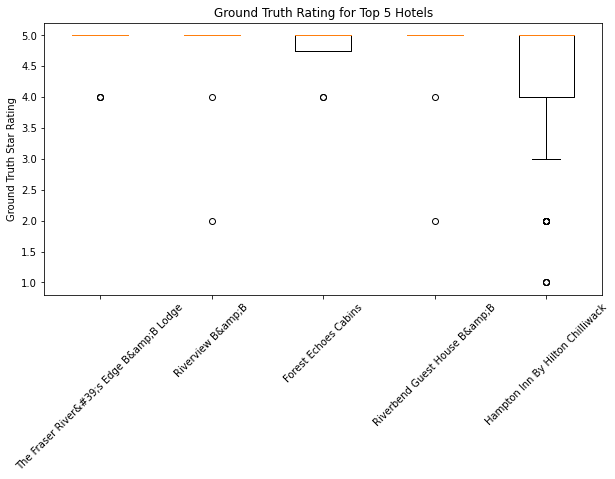

In [83]:
Top5_hotels = AverageGroundTruthRatingTop5['hotelName'].values

hotel_list = []
for hotel in Top5_hotels:
  _hotel = finalDf.loc[finalDf['hotelName'] == hotel]['groundTruth']
  hotel_list.append(_hotel)


# multiple box plots on one figure
plt.figure(figsize=(10,5))
plt.boxplot(hotel_list)
plt.xticks(np.arange(1,6), Top5_hotels, rotation=45)
plt.ylabel('Ground Truth Star Rating')
plt.title('Ground Truth Rating for Top 5 Hotels')
plt.show()

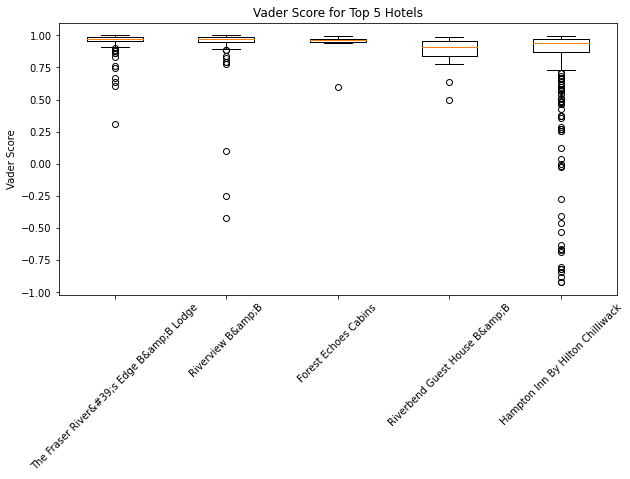

In [84]:
hotel_list2 = []
for hotel in Top5_hotels:
  _hotel = finalDf.loc[finalDf['hotelName'] == hotel]['vader']
  hotel_list2.append(_hotel)


# multiple box plots on one figure
plt.figure(figsize=(10,5))
plt.boxplot(hotel_list2)
plt.xticks(np.arange(1,6), Top5_hotels, rotation=45)
plt.ylabel('Vader Score')
plt.title('Vader Score for Top 5 Hotels')
plt.show()

In [85]:
finalDf_GroundTruth = finalDf.copy()
finalDf_GroundTruth = finalDf_GroundTruth.loc[finalDf_GroundTruth['hotelName'].isin(Top5_hotels)][['hotelName', 'groundTruth']]
finalDf_GroundTruth['newcol'] = finalDf_GroundTruth['groundTruth']
finalDf_GroundTruth.columns = ['hotelName','Average_GroundTruthRating','Variance_GroundTruthRating']
finalDf_GroundTruth = finalDf_GroundTruth.groupby('hotelName').agg({'Average_GroundTruthRating':'mean','Variance_GroundTruthRating':'var'})
finalDf_GroundTruth.reset_index(drop=False).sort_values('Average_GroundTruthRating', ascending = False)

,hotelName,Average_GroundTruthRating,Variance_GroundTruthRating
4,The Fraser River&#39;s Edge B&amp;B Lodge,4.976923,0.022719
3,Riverview B&amp;B,4.960000,0.099394
0,Forest Echoes Cabins,4.750000,0.214286
2,Riverbend Guest House B&amp;B,4.733333,0.638095
1,Hampton Inn By Hilton Chilliwack,4.529412,0.613383


In [86]:
finalDf_Vader = finalDf.copy()
finalDf_Vader = finalDf_Vader.loc[finalDf_Vader['hotelName'].isin(Top5_hotels)][['hotelName', 'vader']]
finalDf_Vader['newcol'] = finalDf_Vader['vader']
finalDf_Vader.columns = ['hotelName','Average_Vader','Variance_Vader']
finalDf_Vader = finalDf_Vader.groupby('hotelName').agg({'Average_Vader':'mean','Variance_Vader':'var'})
finalDf_Vader.reset_index(drop=False).sort_values('Average_Vader', ascending = False)

,hotelName,Average_Vader,Variance_Vader
4,The Fraser River&#39;s Edge B&amp;B Lodge,0.951797,0.007233
3,Riverview B&amp;B,0.926026,0.042151
0,Forest Echoes Cabins,0.918925,0.017140
2,Riverbend Guest House B&amp;B,0.863427,0.019188
1,Hampton Inn By Hilton Chilliwack,0.828365,0.116480


* Boxplots are more informative since they show the distribution of the rating and the score. It shows the max, min, median, and 25th and 75th pecentile as well. Also it shows the ourliers. All these statistics are reflected by graph, which is more visual and intuitive than just using the avg and variance table.

## (c) Scatterplots and heatmaps

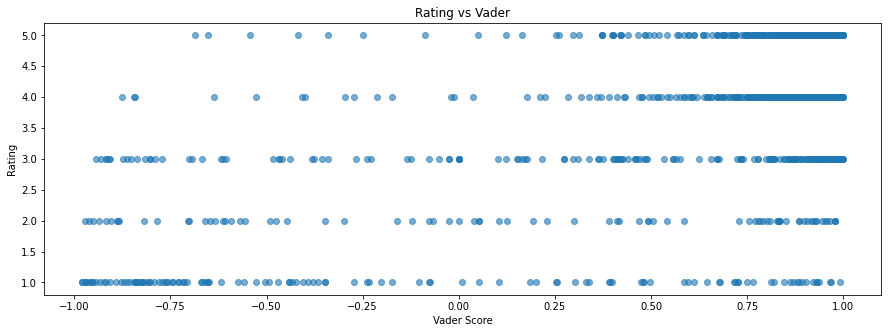

In [87]:
plt.figure(figsize=(15,5))
rating_scores = finalDf['groundTruth'].values
vader_scores = finalDf['vader'].values
plt.plot(vader_scores, rating_scores,"o", alpha=0.6)
plt.title('Rating vs Vader')
plt.ylabel('Rating')
plt.xlabel('Vader Score')
plt.show()

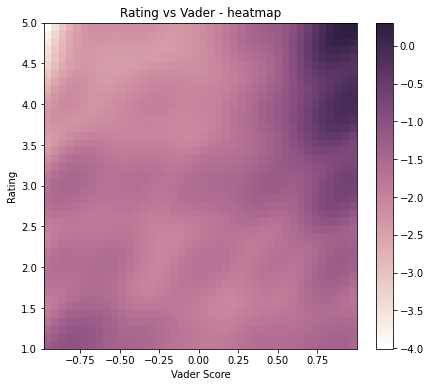

In [88]:
k = gaussian_kde(np.vstack([vader_scores, rating_scores]))
xi, yi = np.mgrid[vader_scores.min():vader_scores.max():vader_scores.size**0.5*1j,rating_scores.min():rating_scores.max():rating_scores.size**0.5*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig, ax = plt.subplots(figsize=(7,6))
b = plt.pcolormesh(xi, yi, np.log10(zi.reshape(xi.shape)), cmap=cmap)
ax.set_xlim(vader_scores.min(), vader_scores.max())
ax.set_ylim(rating_scores.min(), rating_scores.max())
ax.set_xlabel('Vader Score')
ax.set_ylabel('Rating')
ax.set_title('Rating vs Vader - heatmap')
fig.colorbar(b, ax=ax)
fig.show()

* The scatterplot shows the reviews with rating score 1 may have negative vader score, while the reviews with score 4 and 5 may have say more than 0.75 vader score. For review with rating 3 tend to have positive vader score as well while reviews with rating 2 are kind of distrubuted evenly.
* The heatmap also shows similar thing. The difference may be because the rating is human-based, while the vader is rule-based. This informs the rule-based vader is not perfect compared to human judgement. Also the rating is discrete which can be reflected by the heatmap(the uneven distribution of the dark part)

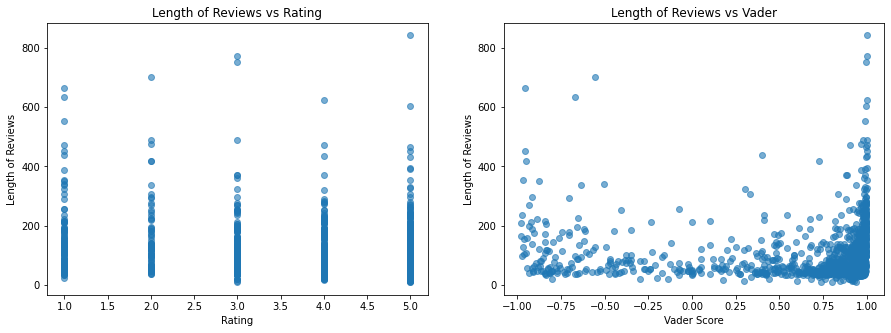

In [89]:
length_reviews = finalDf['reviewColumn'].apply(lambda x: len(x.split()))

fig, ax = plt.subplots(1,2,figsize=(15,5),sharex=False,sharey=False)
rating_scores = finalDf['groundTruth'].values
vader_scores = finalDf['vader'].values
ax[0].plot(rating_scores, length_reviews, "o", alpha=0.6)
ax[1].plot(vader_scores, length_reviews, "o", alpha=0.6)

ax[0].set_title('Length of Reviews vs Rating')
ax[1].set_title('Length of Reviews vs Vader')

ax[0].set_xlabel('Rating')
ax[1].set_xlabel('Vader Score')
for _ax in ax:
  _ax.set_ylabel('Length of Reviews')
fig.show()

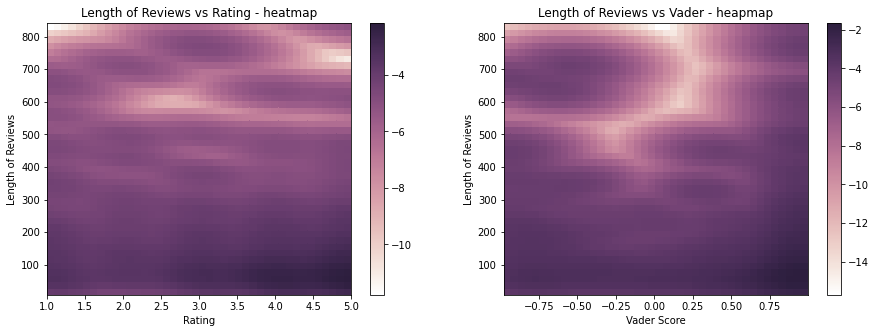

In [90]:
k1 = gaussian_kde(np.vstack([rating_scores, length_reviews]))
k2 = gaussian_kde(np.vstack([vader_scores, length_reviews]))

x1, y1 = np.mgrid[rating_scores.min():rating_scores.max():rating_scores.size**0.5*1j,length_reviews.min():length_reviews.max():length_reviews.size**0.5*1j]
z1 = k1(np.vstack([x1.flatten(), y1.flatten()]))

x2, y2 = np.mgrid[vader_scores.min():vader_scores.max():vader_scores.size**0.5*1j,length_reviews.min():length_reviews.max():length_reviews.size**0.5*1j]
z2 = k2(np.vstack([x2.flatten(), y2.flatten()]))

cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))


b1 = ax1.pcolormesh(x1, y1, np.log10(z1.reshape(x1.shape)), cmap=cmap)
b2 = ax2.pcolormesh(x2, y2, np.log10(z2.reshape(x2.shape)), cmap=cmap)

ax1.set_xlim(rating_scores.min(), rating_scores.max())
ax1.set_ylim(length_reviews.min(), length_reviews.max())
ax2.set_xlim(vader_scores.min(), vader_scores.max())
ax2.set_ylim(length_reviews.min(), length_reviews.max())

ax1.set_xlabel('Rating')
ax1.set_ylabel('Length of Reviews')

ax2.set_xlabel('Vader Score')
ax2.set_ylabel('Length of Reviews')

fig.colorbar(b1, ax=ax1)
fig.colorbar(b2, ax=ax2)

ax1.set_title('Length of Reviews vs Rating - heatmap')
ax2.set_title('Length of Reviews vs Vader - heapmap');

* For the human-based rating, it does not show the relationship between the length of reviews and the score. no matter what the rating is, most reviews have length less than 400.
* However, for the vader score, it shows that people tend to give longer reviews with both high and low vader score but shorter reviews with medium vader score. But most reviews are still under length of 400.

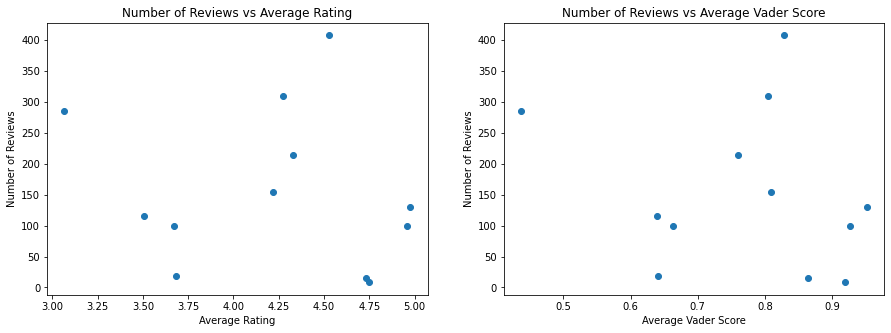

In [91]:
number_reviews = AvgDf['n_reviews'].values

fig, ax = plt.subplots(1,2,figsize=(15,5),sharex=False,sharey=False)
Average_rating = AvgDf['AverageGroundTruthRating'].values
Average_vader = AvgDf['AverageVader'].values
ax[0].plot(Average_rating, number_reviews, "o", alpha=1)
ax[1].plot(Average_vader, number_reviews, "o", alpha=1)

ax[0].set_title('Number of Reviews vs Average Rating')
ax[1].set_title('Number of Reviews vs Average Vader Score')

ax[0].set_xlabel('Average Rating')
ax[1].set_xlabel('Average Vader Score')
for _ax in ax:
  _ax.set_ylabel('Number of Reviews')
fig.show()

* Both plots show similar patten and distribution.
* The high rating and low rating hotels do not have many reviews. while the medium rating hotels have more reviews. This may be because these hotels are fairly newer than the medium rating hotels so there might not be enough visitors. Also this makes sense since there might be not enough visitors and reviews so their ratings are not as representitive as the meduim rating hotels.

(d)

In [92]:
def make_address(row):
  # individual columns need to be combined
    return row['streetAddress']+", "+row['City']+", "+row['Province']

In [93]:
# Need the location for each hotel in a format the tool can handle

geo_rating_df = AvgDf_original\
                         .join(hotelDf.groupby('hotelName')\
                         .agg({'streetAddress':'max','City':'max','Province':'max','postalCode':'max'}))
geo_rating_df['formed_address'] = geo_rating_df.apply(make_address , axis=1)
geo_rating_df.tail()

,n_reviews,AverageGroundTruthRating,AverageVader,streetAddress,City,Province,postalCode,formed_address
hotelName,,,,,,,,
The Fraser River&#39;s Edge B&amp;B Lodge,130,4.976923,0.951797,43037 Old Orchard Rd,Chilliwack,British Columbia,V2R 4A6,"43037 Old Orchard Rd, Chilliwack, British Columbia"
The Royal Hotel Chilliwack,155,4.219355,0.809305,45886 Wellington Ave,Chilliwack,British Columbia,V2P 2C7,"45886 Wellington Ave, Chilliwack, British Columbia"
Travelodge Chilliwack,285,3.066667,0.436826,45466 Yale Rd,Chilliwack,British Columbia,V2R 3Z8,"45466 Yale Rd, Chilliwack, British Columbia"
Vedder River Inn,100,3.670000,0.662507,5788 Vedder Rd,Chilliwack,British Columbia,V2R 1C4,"5788 Vedder Rd, Chilliwack, British Columbia"
White Pillars Country Estate B&amp;B,4,4.500000,0.949250,3195 Karson Rd,Chilliwack,British Columbia,V2R 5H1,"3195 Karson Rd, Chilliwack, British Columbia"


In [94]:
# 0 - need to give the tool a generic name.
locator = Nominatim(user_agent='myGeocoder')
# 1 - conveneint function to delay between geocoding calls
geocode = RateLimiter(locator.geocode, min_delay_seconds=1)
# 2 - form the location string
geo_rating_df['location'] = geo_rating_df['formed_address'].apply(geocode)
# 3 - create longitude, laatitude and altitude from location column (returns tuple)
geo_rating_df['point'] = geo_rating_df['location'].apply(lambda loc: tuple(loc.point) if loc else None)
# 4 - split point column into latitude, longitude and altitude columns
geo_rating_df[['latitude', 'longitude', 'altitude']] = pd.DataFrame(geo_rating_df['point'].tolist(), index=geo_rating_df.index)

geo_rating_df = geo_rating_df[geo_rating_df['n_reviews'] > 5]
geo_rating_df.head()

,n_reviews,AverageGroundTruthRating,AverageVader,streetAddress,City,Province,postalCode,formed_address,location,point,latitude,longitude,altitude
hotelName,,,,,,,,,,,,,
Coast Chilliwack Hotel by APA,215,4.330233,0.760412,45920 First Ave,Chilliwack,British Columbia,V2P 7K1,"45920 First Ave, Chilliwack, British Columbia","(Coast Chilliwack Hotel by APA, 45920, First Avenue, Five Corners, Chilliwack, British Columbia, V2P 7K1, Canada, (49.1682495, -121.95373575917432))","(49.1682495, -121.95373575917432, 0.0)",49.168250,-121.953736,0.0
Comfort Inn,115,3.504348,0.639842,45405 Luckakuck Way,Chilliwack,British Columbia,V2R 3C7,"45405 Luckakuck Way, Chilliwack, British Columbia","(Comfort Inn Chilliwack, 45405, Luckakuck Way, Chilliwack, British Columbia, V2R 3P3, Canada, (49.1428979, -121.96710482449545))","(49.1428979, -121.96710482449545, 0.0)",49.142898,-121.967105,0.0
Forest Echoes Cabins,8,4.750000,0.918925,45825 Edmeston Rd,Cultus Lake,British Columbia,V2R 5A3,"45825 Edmeston Rd, Cultus Lake, British Columbia","(Edmeston Road, Area H (Cultus Lake/Columbia Valley), British Columbia, V2R 5A3, Canada, (49.0598621, -121.9596791))","(49.0598621, -121.9596791, 0.0)",49.059862,-121.959679,0.0
Hampton Inn By Hilton Chilliwack,408,4.529412,0.828365,8050 Lickman Rd,Chilliwack,British Columbia,V2R 0Y3,"8050 Lickman Rd, Chilliwack, British Columbia","(Hampton Inn by Hilton Chilliwack, 8050, Lickman Road, Chilliwack, British Columbia, V2R 4A7, Canada, (49.148608499999995, -122.002646324))","(49.148608499999995, -122.002646324, 0.0)",49.148608,-122.002646,0.0
Rainbow Motor Inn,19,3.684211,0.640511,45620 Yale Rd,Chilliwack,British Columbia,V2P 2N2,"45620 Yale Rd, Chilliwack, British Columbia","(Rainbow Motor Inn, 45620, Yale Road, Chilliwack, British Columbia, V2P 2N3, Canada, (49.1542257, -121.961208))","(49.1542257, -121.961208, 0.0)",49.154226,-121.961208,0.0


In [95]:
colormap = cm.LinearColormap(colors=[(68,1,84),(49,104,142),(53,183,121),(253,231,37)], index=[2,3,4,5],vmin=2,vmax=5)
AverageGroundTruthRating_list = list(geo_rating_df.AverageGroundTruthRating)

In [96]:
avg_latitude = geo_rating_df['latitude'].mean()
avg_longitude = geo_rating_df['longitude'].mean()


map1 = folium.Map(
    location=[avg_latitude, avg_longitude], # <- this will need to be set based on your own hotels
    tiles='cartodbpositron',
    zoom_start=12,
)

coordinates = zip(geo_rating_df.latitude, geo_rating_df.longitude)
for coordinate, rating in zip(coordinates, AverageGroundTruthRating_list):
    folium.CircleMarker(
        location = coordinate,
        radius=10,
        fill=True,
        color=colormap(rating),
        fill_opacity = 1
    ).add_to(map1)

map1.add_child(colormap)
map1

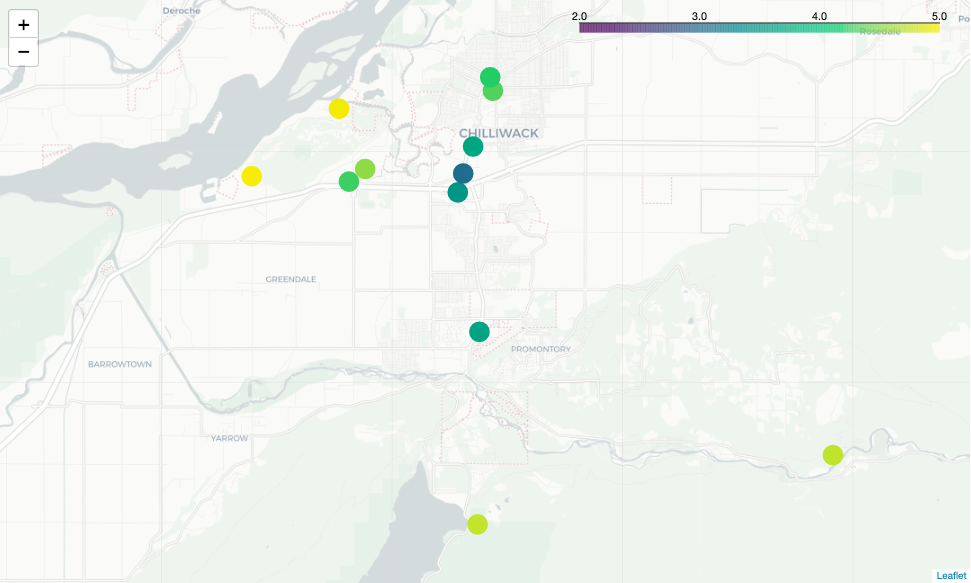

In [97]:
## folium graphs are best saved as screenshot images to be reloaded into the notebook
Image('demo.png')

* There are some relations between the location and the reviews. The hotels inside the city tend to have lower rating and more negative reviews may be bacause of the noise and the surrounding enviroment in the city are not perfect. The hotels that are far from the city tend to have more positive reviews. This may be because many tourist attractions are outside the city and as we can see, the hotels near the lakes tend to have higher rating.
* I would recommend to stay ourside the city(beside the lakes)

(e)

In [98]:
AvgDf_soted = AvgDf.reset_index(drop=False)\
                               .sort_values('AverageGroundTruthRating',ascending=False)[['hotelName','AverageGroundTruthRating','n_reviews']]
AvgDf_soted

,hotelName,AverageGroundTruthRating,n_reviews
8,The Fraser River&#39;s Edge B&amp;B Lodge,4.976923,130
6,Riverview B&amp;B,4.960000,100
2,Forest Echoes Cabins,4.750000,8
5,Riverbend Guest House B&amp;B,4.733333,15
3,Hampton Inn By Hilton Chilliwack,4.529412,408
0,Coast Chilliwack Hotel by APA,4.330233,215
7,SureStay Hotel By Best Western Chilliwack,4.270968,310
9,The Royal Hotel Chilliwack,4.219355,155
4,Rainbow Motor Inn,3.684211,19
11,Vedder River Inn,3.670000,100


2 highly rated hotels:

*   The Fraser River&#39;s Edge B&amp;B Lodge (4.98 rating, 130 reviews)
*   Riverview B&amp;B (4.96 rating, 100 reviews)

2 lowly rated hotels:
*   Comfort Inn (3.50 rating, 115 reviews)
*   Travelodge Chilliwack (3.07 rating, 285 reviews)

2 mediocre rated hotels:
*   Coast Chilliwack Hotel by APA (4.33 rating, 215 reviews)
*   SureStay Hotel By Best Western Chilliwack (4.27 rating, 310 reviews)

In [99]:
six_hotels = np.array(['The Fraser River&#39;s Edge B&amp;B Lodge', 'Riverview B&amp;B', 'Comfort Inn', 'Travelodge Chilliwack','Coast Chilliwack Hotel by APA','SureStay Hotel By Best Western Chilliwack'])

In [100]:
#Drop rows that do not match certain date_stamp format
date_stampDf = hotelDf[~hotelDf.date_stamp.str.contains('|'.join(['ago', 'yesterday']))].reset_index(drop=True)

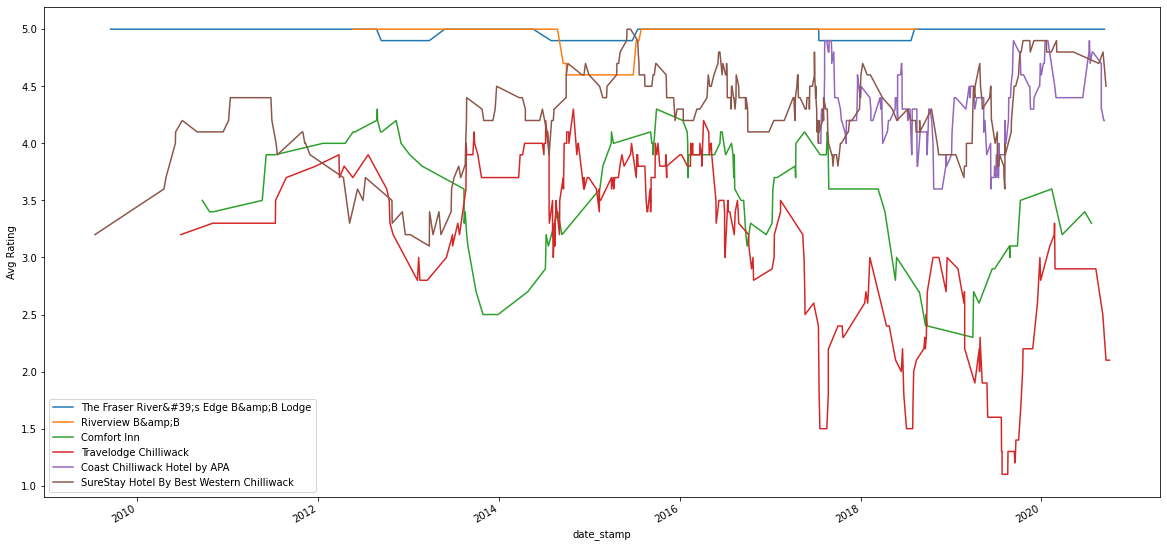

In [101]:
# It can be useful to see when reviews were being made and how the ratings changed using a running mean
plt.figure(figsize=(20,10))

for hotel in six_hotels: 
  _df = date_stampDf[date_stampDf['hotelName']==hotel].set_index('date_stamp')
  _df.index = pd.to_datetime(_df.index)
  _df = _df.sort_index()
  _df['groundTruth'].rolling(10).mean().plot(label=hotel)

plt.ylabel('Avg Rating')
plt.legend()
plt.show()

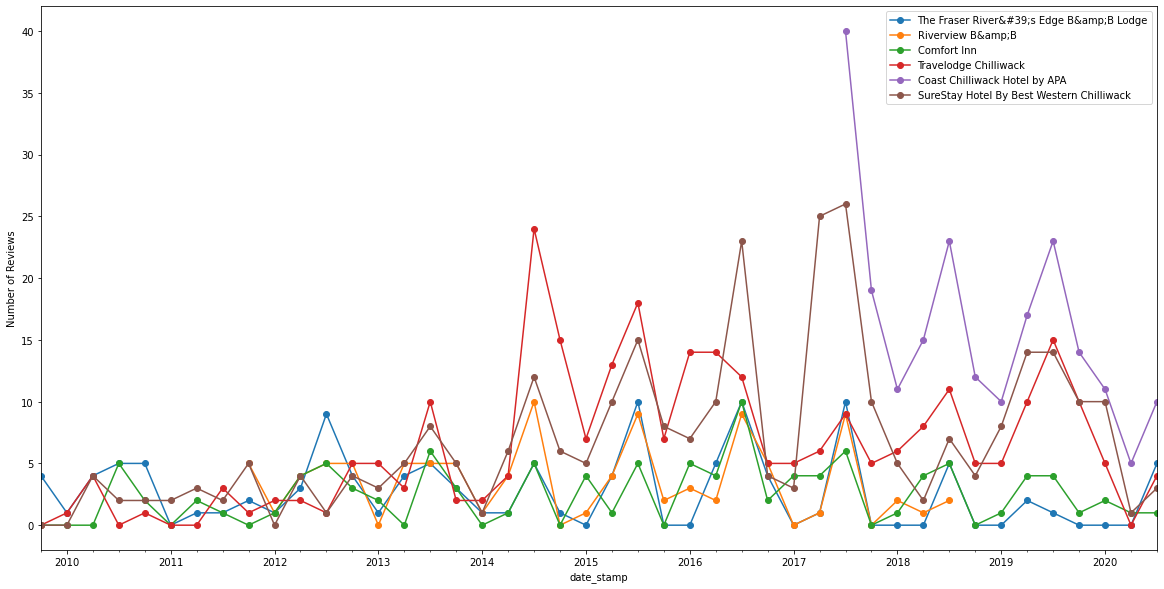

In [102]:
#Plot based on Querter End frequency
plt.figure(figsize=(20,10))

for hotel in six_hotels: 
  _df = date_stampDf[date_stampDf['hotelName']==hotel].set_index('date_stamp')
  _df.index = pd.to_datetime(_df.index)
  _df = _df.sort_index()
  _df['count'] = 1
  _df_monthly = _df.groupby(pd.Grouper(freq='Q')).agg({'count':'sum'}) #M is month
  _df_monthly = _df_monthly['12/31/2009':'09/30/2020']

  _df_monthly['count'].plot(label=hotel, marker='o')

plt.ylabel('Number of Reviews')
plt.legend()
plt.show()

* To make the plot more concise, I take the rolling of 10. The highly rated hotels ratings are much more consistant. While the lowly rated hotels ratings are fluctuating so much during different time. And as time goes by, their ratings tend to go down.
* I took the year between 2010 to 2020 which is the recent 10 years. This plot shows that before 2015, there are fewer reviews. There are more reviews during the sumer of 2014, 2016, 2017, 2019. This shows that people like to go to this city in summer time. Also, the Coast Chilliwack Hotel had huge nubmer of reviews when it was just opened but the number reviews droped a lot after 2020.